## SF crime data analysis and modeling

### In this notebook, I will use Spark SQL for big data analysis on SF crime data. (https://data.sfgov.org/Public-Safety/sf-data/skgt-fej3/data). 

The first part is EDA of the crimes. 
The second part is unsupervised learning for spatial data analysis.
The third part is the time series data analysis   

**Note**: I download the small data (one month) for debug, then the data from 2013 to 2018 for testing and analysis.

In [3]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ggplot import *
import warnings

import os
os.environ["PYSPARK_PYTHON"] = "python3"


In [4]:
# read data from the data storage
# crime_data_lines = sc.textFile('/FileStore/tables/sf_data_short.csv')
crime_data_lines = sc.textFile('/FileStore/tables/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')

#prepare data 
df_crimes = crime_data_lines.map(lambda line: [x.strip('"') for x in next(reader([line]))])
#get header
header = df_crimes.first()
header

Out[ 2 ]: 
['IncidntNum',
 'Category',
 'Descript',
 'DayOfWeek',
 'Date',
 'Time',
 'PdDistrict',
 'Resolution',
 'Address',
 'X',
 'Y',
 'Location',
 'PdId']

In [5]:
#remove the first line of data
crimes = df_crimes.filter(lambda x: x != header)

#get the first line of data
display(crimes.take(2))

_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,_11,_12,_13
150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.42158168137,37.7617007179518,"(37.7617007179518, -122.42158168137)",15006027571000
150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406029855,37.7841907151119,"(37.7841907151119, -122.414406029855)",15009821003074


In [6]:
#get the total number of data 
print(crimes.count())

2215024

#### Solove  big data issues via Spark

There are 3 options to transform distributed data into dataframe and SQL table. I will mainly use the dataframe approach.

approach 1: use RDD   
approach 2: use Dataframe, register the RDD to a dataframe      
approach 3: use SQL

In [8]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df_opt1 = spark.read.format("csv").option("header", "true").load("/FileStore/tables/sf_data_short.csv")
display(df_opt1)
df_opt1.createOrReplaceTempView("sf_crime")

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
176184067,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2017,18:15,SOUTHERN,NONE,SHIPLEY ST / 4TH ST,-122.40061739890338,37.7815876234701,"(37.7815876234701, -122.40061739890338)",17618406706244
176183906,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2017,09:45,PARK,NONE,HAYES ST / SCOTT ST,-122.43613031282463,37.775205514978545,"(37.775205514978545, -122.43613031282463)",17618390606244
176183423,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2017,10:50,TARAVAL,NONE,KIRKHAM ST / LA PLAYA ST,-122.50910925205717,37.75841171643452,"(37.75841171643452, -122.50910925205717)",17618342306244
176182776,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2017,18:00,RICHMOND,NONE,100 Block of LAKE ST,-122.46095180410846,37.78689526736518,"(37.78689526736518, -122.46095180410846)",17618277606244
176182754,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2017,07:15,RICHMOND,NONE,POINTLOBOS AV / 48TH AV,-122.50943307434102,37.779849075879056,"(37.779849075879056, -122.50943307434102)",17618275406244
176182538,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Tuesday,07/11/2017,10:00,PARK,NONE,2200 Block of HAYES ST,-122.4534813455352,37.773052871338244,"(37.773052871338244, -122.4534813455352)",17618253806372
176182522,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2017,12:00,RICHMOND,NONE,500 Block of JOHNFKENNEDY DR,-122.46620466789287,37.772540539159316,"(37.772540539159316, -122.46620466789287)",17618252206244
176181778,BURGLARY,"BURGLARY, UNLAWFUL ENTRY",Tuesday,07/11/2017,14:43,TARAVAL,NONE,1800 Block of 10TH AV,-122.4667330308776,37.753714592060966,"(37.753714592060966, -122.4667330308776)",17618177805073
176181762,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2017,18:45,TARAVAL,NONE,17TH AV / TARAVAL ST,-122.4735538773959,37.74314326922748,"(37.74314326922748, -122.4735538773959)",17618176206244
176181665,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Tuesday,07/11/2017,20:44,SOUTHERN,NONE,800 Block of BRYANT ST,-122.40340479147905,37.775420706711,"(37.775420706711, -122.40340479147905)",17618166506372


In [9]:
# I will transform the RDD to dataframe, which would be easier to handle and explore. 
# First, I will convert RDD elements to RDD Row objects. 
from pyspark.sql import Row

def createRow(keys, values):
  """
  define a function below to take a list of column names (header) and a list of values (one row of our data) and then create a RDD Row of key-value pairs.
  """
  assert len(keys) == len(values)
  mapped = dict(zip(keys, values))
  return Row(**mapped)# use ** to unpack the dictionary to become "key = value" pairs

# map the defined function to convert all the rows of our data to RDD row objects and then create a dataframe.
rdd_rows = crimes.map(lambda x: createRow(header, x))

df_opt2 = spark.createDataFrame(rdd_rows)
df_opt2.createOrReplaceTempView("sf_crime")
display(df_opt2)

Address,Category,Date,DayOfWeek,Descript,IncidntNum,Location,PdDistrict,PdId,Resolution,Time,X,Y
18TH ST / VALENCIA ST,NON-CRIMINAL,01/19/2015,Monday,LOST PROPERTY,150060275,"(37.7617007179518, -122.42158168137)",MISSION,15006027571000,NONE,14:00,-122.42158168137,37.7617007179518
300 Block of LEAVENWORTH ST,ROBBERY,02/01/2015,Sunday,"ROBBERY, BODILY FORCE",150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,15009821003074,NONE,15:45,-122.414406029855,37.7841907151119
300 Block of LEAVENWORTH ST,ASSAULT,02/01/2015,Sunday,AGGRAVATED ASSAULT WITH BODILY FORCE,150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,15009821004014,NONE,15:45,-122.414406029855,37.7841907151119
300 Block of LEAVENWORTH ST,SECONDARY CODES,02/01/2015,Sunday,DOMESTIC VIOLENCE,150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,15009821015200,NONE,15:45,-122.414406029855,37.7841907151119
LOMBARD ST / LAGUNA ST,VANDALISM,01/27/2015,Tuesday,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",150098226,"(37.8004687042875, -122.431118543788)",NORTHERN,15009822628160,NONE,19:00,-122.431118543788,37.8004687042875
400 Block of LOCUST ST,NON-CRIMINAL,02/01/2015,Sunday,AIDED CASE -PROPERTY FOR DESTRUCTION,150098232,"(37.7870853907529, -122.451781767894)",RICHMOND,15009823251041,NONE,16:21,-122.451781767894,37.7870853907529
700 Block of KIRKWOOD AV,SECONDARY CODES,01/31/2015,Saturday,DOMESTIC VIOLENCE,150098248,"(37.729203356539, -122.374019331833)",BAYVIEW,15009824815200,NONE,21:00,-122.374019331833,37.729203356539
700 Block of KIRKWOOD AV,VANDALISM,01/31/2015,Saturday,"MALICIOUS MISCHIEF, VANDALISM",150098248,"(37.729203356539, -122.374019331833)",BAYVIEW,15009824828150,NONE,21:00,-122.374019331833,37.729203356539
200 Block of STOCKTON ST,BURGLARY,01/31/2015,Saturday,"BURGLARY OF STORE, UNLAWFUL ENTRY",150098254,"(37.7878092959561, -122.40656817787)",CENTRAL,15009825405053,NONE,16:09,-122.40656817787,37.7878092959561
800 Block of GEARY ST,LARCENY/THEFT,01/31/2015,Saturday,PETTY THEFT SHOPLIFTING,150098260,"(37.7862578545865, -122.417295322526)",CENTRAL,15009826006362,NONE,17:00,-122.417295322526,37.7862578545865


In [10]:
df = df_opt2
df.show()

+--------------------+---------------+----------+---------+--------------------+----------+--------------------+----------+--------------+--------------+-----+-----------------+----------------+
 Address| Category| Date|DayOfWeek| Descript|IncidntNum| Location|PdDistrict| PdId| Resolution| Time| X| Y|
+--------------------+---------------+----------+---------+--------------------+----------+--------------------+----------+--------------+--------------+-----+-----------------+----------------+
18TH ST / VALENCI...| NON-CRIMINAL|01/19/2015| Monday| LOST PROPERTY| 150060275|(37.7617007179518...| MISSION|15006027571000| NONE|14:00| -122.42158168137|37.7617007179518|
300 Block of LEAV...| ROBBERY|02/01/2015| Sunday|ROBBERY, BODILY F...| 150098210|(37.7841907151119...|TENDERLOIN|15009821003074| NONE|15:45|-122.414406029855|37.7841907151119|
300 Block of LEAV...| ASSAULT|02/01/2015| Sunday|AGGRAVATED ASSAUL...| 150098210|(37.7841907151119...|TENDERLOIN|15009821004014| NONE|15:45|-122.414406029855|37.7841907151119|
300 Block of LEAV...|SECONDARY CODES|02/01/2015| Sunday| DOMESTIC VIOLENCE| 150098210|(37.7841907151119...|TENDERLOIN|15009821015200| NONE|15:45|-122.414406029855|37.7841907151119|
LOMBARD ST / LAGU...| VANDALISM|01/27/2015| Tuesday|MALICIOUS MISCHIE...| 150098226|(37.8004687042875...| NORTHERN|15009822628160| NONE|19:00|-122.431118543788|37.8004687042875|
400 Block of LOCU...| NON-CRIMINAL|02/01/2015| Sunday|AIDED CASE -PROPE...| 150098232|(37.7870853907529...| RICHMOND|15009823251041| NONE|16:21|-122.451781767894|37.7870853907529|
700 Block of KIRK...|SECONDARY CODES|01/31/2015| Saturday| DOMESTIC VIOLENCE| 150098248|(37.729203356539,...| BAYVIEW|15009824815200| NONE|21:00|-122.374019331833| 37.729203356539|
700 Block of KIRK...| VANDALISM|01/31/2015| Saturday|MALICIOUS MISCHIE...| 150098248|(37.729203356539,...| BAYVIEW|15009824828150| NONE|21:00|-122.374019331833| 37.729203356539|
200 Block of STOC...| BURGLARY|01/31/2015| Saturday|BURGLARY OF STORE...| 150098254|(37.7878092959561...| CENTRAL|15009825405053| NONE|16:09| -122.40656817787|37.7878092959561|
800 Block of GEAR...| LARCENY/THEFT|01/31/2015| Saturday|PETTY THEFT SHOPL...| 150098260|(37.7862578545865...| CENTRAL|15009826006362| NONE|17:00|-122.417295322526|37.7862578545865|
1700 Block of HAR...| LARCENY/THEFT|02/01/2015| Sunday|PETTY THEFT SHOPL...| 150098345|(37.7690748003847...| MISSION|15009834506362|ARREST, BOOKED|14:00|-122.413354187018|37.7690748003847|
1700 Block of HAR...| DRUG/NARCOTIC|02/01/2015| Sunday|POSSESSION OF MET...| 150098345|(37.7690748003847...| MISSION|15009834516650|ARREST, BOOKED|14:00|-122.413354187018|37.7690748003847|
1700 Block of HAR...| DRUG/NARCOTIC|02/01/2015| Sunday|POSSESSION OF NAR...| 150098345|(37.7690748003847...| MISSION|15009834516710|ARREST, BOOKED|14:00|-122.413354187018|37.7690748003847|
1700 Block of HAR...| WARRANTS|02/01/2015| Sunday| WARRANT ARREST| 150098345|(37.7690748003847...| MISSION|15009834563010|ARREST, BOOKED|14:00|-122.413354187018|37.7690748003847|
2200 Block of MAR...| ROBBERY|02/01/2015| Sunday|ROBBERY, ARMED WI...| 150098367|(37.7651107322703...| MISSION|15009836703072| NONE|16:20|-122.432198022433|37.7651107322703|
FRANKLIN ST / TUR...| VEHICLE THEFT|02/01/2015| Sunday| STOLEN AUTOMOBILE| 150098373|(37.7817528767881...| NORTHERN|15009837307021| NONE|12:45| -122.42227702764|37.7817528767881|
FRANKLIN ST / TUR...| NON-CRIMINAL|02/01/2015| Sunday| FOUND PROPERTY| 150098373|(37.7817528767881...| NORTHERN|15009837372000| NONE|12:45| -122.42227702764|37.7817528767881|
3800 Block of 3RD ST| WARRANTS|02/01/2015| Sunday|ENROUTE TO OUTSID...| 150098389|(37.7422600519555...| BAYVIEW|15009838962050|ARREST, BOOKED|16:38|-122.387939452192|37.7422600519555|
MARTIN LUTHER KIN...| LARCENY/THEFT|02/01/2015| Sunday|PETTY THEFT FROM ...| 150098395|(37.7671999403456...| PARK|15009839506243| NONE|14:30|-122.458638758608|37.7671999403456|
NEWCOMB AV / MEND...| OTHER OFFENSES|02/01/2015| Sunday|DRIVERS LICENSE, ...| 1500984

In [11]:
df_opt3 = crimes.toDF(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId'])
display(df_opt3)
df_opt3.createOrReplaceTempView("sf_crime")

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
176184067,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2017,18:15,SOUTHERN,NONE,SHIPLEY ST / 4TH ST,-122.40061739890338,37.7815876234701,"(37.7815876234701, -122.40061739890338)",17618406706244
176183906,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2017,09:45,PARK,NONE,HAYES ST / SCOTT ST,-122.43613031282463,37.775205514978545,"(37.775205514978545, -122.43613031282463)",17618390606244
176183423,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2017,10:50,TARAVAL,NONE,KIRKHAM ST / LA PLAYA ST,-122.50910925205717,37.75841171643452,"(37.75841171643452, -122.50910925205717)",17618342306244
176182776,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2017,18:00,RICHMOND,NONE,100 Block of LAKE ST,-122.46095180410846,37.78689526736518,"(37.78689526736518, -122.46095180410846)",17618277606244
176182754,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2017,07:15,RICHMOND,NONE,POINTLOBOS AV / 48TH AV,-122.50943307434102,37.779849075879056,"(37.779849075879056, -122.50943307434102)",17618275406244
176182538,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Tuesday,07/11/2017,10:00,PARK,NONE,2200 Block of HAYES ST,-122.4534813455352,37.773052871338244,"(37.773052871338244, -122.4534813455352)",17618253806372
176182522,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2017,12:00,RICHMOND,NONE,500 Block of JOHNFKENNEDY DR,-122.46620466789287,37.772540539159316,"(37.772540539159316, -122.46620466789287)",17618252206244
176181778,BURGLARY,"BURGLARY, UNLAWFUL ENTRY",Tuesday,07/11/2017,14:43,TARAVAL,NONE,1800 Block of 10TH AV,-122.4667330308776,37.753714592060966,"(37.753714592060966, -122.4667330308776)",17618177805073
176181762,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2017,18:45,TARAVAL,NONE,17TH AV / TARAVAL ST,-122.4735538773959,37.74314326922748,"(37.74314326922748, -122.4735538773959)",17618176206244
176181665,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Tuesday,07/11/2017,20:44,SOUTHERN,NONE,800 Block of BRYANT ST,-122.40340479147905,37.775420706711,"(37.775420706711, -122.40340479147905)",17618166506372


In [12]:
# replace tow column names, "X" and "Y", with "Longitude" and "Latitude", and change their types to float
df = df.withColumn('X', df['X'].cast('float')).withColumn('Y', df['Y'].cast('float'))
df = df.withColumnRenamed('X','Longitude').withColumnRenamed('Y','Latitude')

In [13]:
# inspect the schema of the data frame
df.printSchema()

root
-- Address: string (nullable = true)
-- Category: string (nullable = true)
-- Date: string (nullable = true)
-- DayOfWeek: string (nullable = true)
-- Descript: string (nullable = true)
-- IncidntNum: string (nullable = true)
-- Location: string (nullable = true)
-- PdDistrict: string (nullable = true)
-- PdId: string (nullable = true)
-- Resolution: string (nullable = true)
-- Time: string (nullable = true)
-- Longitude: float (nullable = true)
-- Latitude: float (nullable = true)

##### EDA1: counts the number of crimes for different category.

In [15]:
# option 1: just use the functions of RDD
catorgory_set_rdd = crimes.map(lambda item: (item[1],1))
from operator import add
result = sorted(catorgory_set_rdd.reduceByKey(add).collect(), key = lambda item: -item[1])
display(result)

_1,_2
LARCENY/THEFT,2805
OTHER OFFENSES,1002
NON-CRIMINAL,991
ASSAULT,780
VANDALISM,650
VEHICLE THEFT,353
SUSPICIOUS OCC,312
WARRANTS,312
BURGLARY,302
MISSING PERSON,265


In [16]:
# option 2: dataframe 
q1_result = df.groupBy('category').count().orderBy('count', ascending=False)
display(q1_result)

category,count
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323
ASSAULT,194694
VEHICLE THEFT,126602
DRUG/NARCOTIC,119628
VANDALISM,116059
WARRANTS,101379
BURGLARY,91543
SUSPICIOUS OCC,80444


In [17]:
#option 3: Spark SQL based
crimeCategory = spark.sql("SELECT category, COUNT(*) AS Count FROM sf_crime GROUP BY category ORDER BY Count DESC")
display(crimeCategory)

category,Count
LARCENY/THEFT,2805
OTHER OFFENSES,1002
NON-CRIMINAL,991
ASSAULT,780
VANDALISM,650
VEHICLE THEFT,353
WARRANTS,312
SUSPICIOUS OCC,312
BURGLARY,302
MISSING PERSON,265


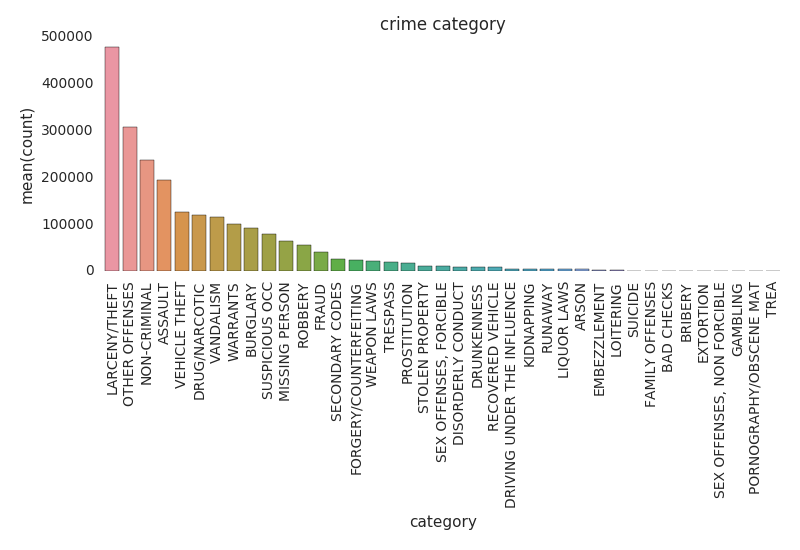

In [18]:
q1_result_pd_df = q1_result.toPandas()

fig, ax = plt.subplots()
ax.set_title('crime category')
#ax.set_xlabel('category')
#ax.set_ylabel('Latitude')
ax.set_xticklabels(q1_result_pd_df['category'], rotation=90)

ax = sns.barplot(x="category", y="count", data=q1_result_pd_df)
plt.tight_layout()

display(fig)

##### EDA2 Counts the number of crimes for different districts

In [20]:
# option 1: just use the functions of RDD
rdd = crimes.map(lambda item: (item[6],1))
result = sorted(rdd.countByKey().items(), key = lambda item: -item[1])
display(result)

_1,_2
SOUTHERN,1745
MISSION,1191
NORTHERN,1173
CENTRAL,1137
BAYVIEW,817
INGLESIDE,670
TARAVAL,662
TENDERLOIN,536
RICHMOND,527
PARK,519


In [21]:
df.select("PdDistrict").distinct().show()

+----------+
PdDistrict|
+----------+
 MISSION|
 BAYVIEW|
 CENTRAL|
 TARAVAL|
TENDERLOIN|
 INGLESIDE|
 PARK|
 SOUTHERN|
 RICHMOND|
 |
 NORTHERN|
+----------+

In [22]:
df = df.filter(df.PdDistrict.isin(['MISSION', 'BAYVIEW', 'CENTRAL', 'TARAVAL','TENDERLOIN','INGLESIDE','PARK','SOUTHERN','RICHMOND','NORTHERN']))


In [23]:
df.select("PdDistrict").distinct().show()

+----------+
PdDistrict|
+----------+
 MISSION|
 BAYVIEW|
 CENTRAL|
 TARAVAL|
TENDERLOIN|
 INGLESIDE|
 PARK|
 SOUTHERN|
 RICHMOND|
 NORTHERN|
+----------+

In [24]:
# option 2: dataframe 
q2_result = df.groupBy('PdDistrict').count().orderBy('count', ascending=False)
q2_result.show()

+----------+------+
PdDistrict| count|
+----------+------+
 SOUTHERN|399785|
 MISSION|300076|
 NORTHERN|272713|
 CENTRAL|226255|
 BAYVIEW|221000|
 INGLESIDE|194180|
TENDERLOIN|191746|
 TARAVAL|166971|
 PARK|125479|
 RICHMOND|116818|
+----------+------+

In [25]:
#option 3: Spark SQL based
df_sql = spark.sql("SELECT PdDistrict, COUNT(*) AS Count FROM sf_crime GROUP BY PdDistrict ORDER BY Count DESC")
df_sql.show()

+----------+-----+
PdDistrict|Count|
+----------+-----+
 SOUTHERN| 1745|
 MISSION| 1191|
 NORTHERN| 1173|
 CENTRAL| 1137|
 BAYVIEW| 817|
 INGLESIDE| 670|
 TARAVAL| 662|
TENDERLOIN| 536|
 RICHMOND| 527|
 PARK| 519|
+----------+-----+

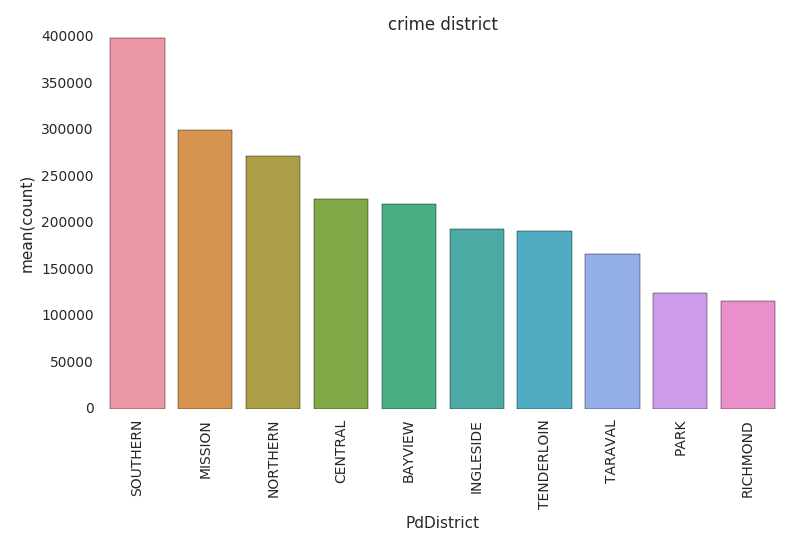

In [26]:
q2_result_pd_df = q2_result.toPandas()

fig, ax = plt.subplots()
ax.set_title('crime district')
#ax.set_xlabel('category')
#ax.set_ylabel('Latitude')
ax.set_xticklabels(q2_result_pd_df['PdDistrict'], rotation=90)

ax = sns.barplot(x="PdDistrict", y="count", data=q2_result_pd_df)
plt.tight_layout()

display(fig)

##### EDA3: Count the number of crimes each "Sunday" at "SF downtown". 

SF downtown is defined via the range of spatial location. Thus, I need to write your own UDF function to filter data which are located inside certain spatial range (https://changhsinlee.com/pyspark-udf/)

Here I define "downtown" as an area within 0.005 degree from (Lat, Long) = (37.792489, -122.403221). This area roughly includes Financial District, China Town and Union Square.

In [28]:
# option 2: dataframe 
df_downtown = df.filter((df['Latitude'] - 37.792489)**2 + (df['Longitude'] + 122.403221)**2 < 0.005**2)

df_downtown.filter(df_downtown['DayOfWeek'] == 'Sunday').groupBy("Date", "DayOfWeek").count().orderBy('Date').show()

+----------+---------+-----+
 Date|DayOfWeek|count|
+----------+---------+-----+
07/16/2017| Sunday| 10|
07/23/2017| Sunday| 20|
07/30/2017| Sunday| 14|
+----------+---------+-----+

In [29]:
from pyspark.sql import functions as F

#simple filter function
@F.udf(returnType=BooleanType())

def downtown_filter(lat, lon):
    return ((lat - 37.792489)**2 + (lon + 122.403221)**2)< 0.005**2 

In [30]:
df_downtown = df.filter(downtown_filter('Latitude', 'Longitude'))

In [31]:
df_downtown.filter(df_downtown['DayOfWeek'] == 'Sunday').groupBy("Date", "DayOfWeek").count().orderBy('Date').show()

+----------+---------+-----+
 Date|DayOfWeek|count|
+----------+---------+-----+
01/01/2006| Sunday| 16|
01/01/2012| Sunday| 14|
01/01/2017| Sunday| 15|
01/02/2005| Sunday| 4|
01/02/2011| Sunday| 4|
01/03/2010| Sunday| 6|
01/03/2016| Sunday| 8|
01/04/2004| Sunday| 8|
01/04/2009| Sunday| 4|
01/04/2015| Sunday| 13|
01/05/2003| Sunday| 9|
01/05/2014| Sunday| 4|
01/06/2008| Sunday| 5|
01/06/2013| Sunday| 6|
01/07/2007| Sunday| 5|
01/07/2018| Sunday| 13|
01/08/2006| Sunday| 3|
01/08/2012| Sunday| 4|
01/08/2017| Sunday| 8|
01/09/2005| Sunday| 6|
+----------+---------+-----+
only showing top 20 rows

In [32]:
#option 3: Spark SQL based. X: Longitude Y: Latitude
df_sql = spark.sql("SELECT Date, DayOfWeek, COUNT(*) AS Count FROM sf_crime \
                   where DayOfWeek = 'Sunday' and \
                   pow(Y - 37.792489, 2) + pow(X + 122.403221, 2) < pow(0.005, 2) \
                   group by Date, DayOfWeek order by Date")
display(df_sql)

Date,DayOfWeek,Count
07/16/2017,Sunday,10
07/23/2017,Sunday,20
07/30/2017,Sunday,14


##### EDA 4: Analysis the number of crime in each month of the recent years (2015, 2016, 2017, 2018). Then, give my insights for business impact of my results.

In [35]:
from pyspark.sql.functions import *

#df = df_opt2

df = df.withColumn('Date_ts', from_unixtime(unix_timestamp('Date', 'MM/dd/yyy')))

df = df.withColumn('year', year(df.Date_ts))
df = df.withColumn('month', month(df.Date_ts))
df = df.withColumn('day', dayofmonth(df.Date_ts))

#display(df)

In [36]:
q4_result = df.groupBy('year','month').count().orderBy('year', ascending=False)
#q4_result.show()

In [37]:
q4_result_pd_df = q4_result.toPandas()

In [38]:
# q4_result_pd_df[q4_result_pd_df.year == 2018].head()

Out[ 20 ]: 
 year month count
0 2018 1 12031
1 2018 3 10740
2 2018 5 3644
3 2018 2 9947
4 2018 4 10306

In [39]:
#q4_result_pd_df.groupby('year')['count'].sum().values

Out[ 191 ]: 
array([149176, 148148, 142186, 137853, 137639, 141311, 139860, 133523,
 132697, 140847, 152806, 150128, 156526, 150883, 154773, 46668])

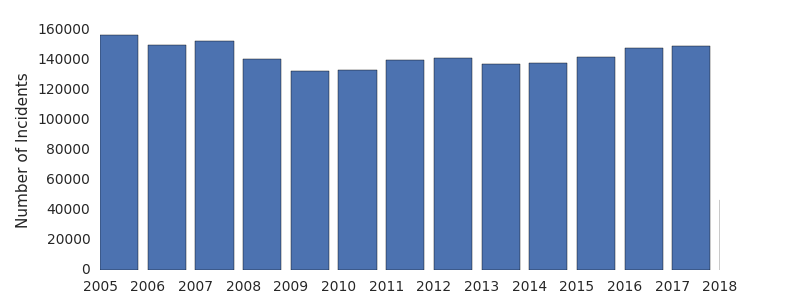

In [40]:
# visulize in a bar plot
fig, ax = plt.subplots(figsize=[8,3])
ax.bar(sorted(q4_result_pd_df.year.value_counts().index), q4_result_pd_df.groupby('year')['count'].sum().values[np.argsort(q4_result_pd_df.year.value_counts().index)])

ax.set_xlabel('Year')
ax.set_ylabel('Number of Incidents')
ax.set_xlim((2005,2018))
#plt.ylim((150000,200000))
ax.set_xticks(np.arange(2005,2019) )
display(fig)

In [41]:
def crime_per_month(df, yr):
  df2 = df[df.year == yr].sort_values(by='month')
  return df2

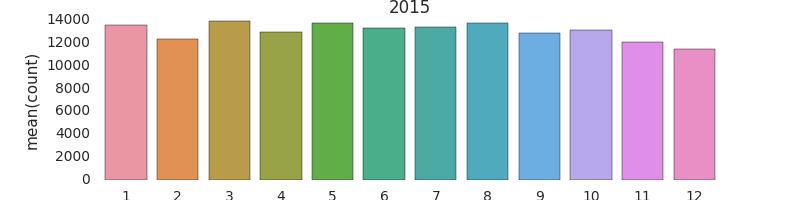

In [42]:
fig, (ax1) = plt.subplots(figsize=(8,2))
item = 2015
tmp = crime_per_month(q4_result_pd_df, item)
ax1 = sns.barplot(x="month", y="count", data=tmp)
ax1.set_xticklabels(tmp['month'], rotation=0)
ax1.set_title(item)
display(fig)

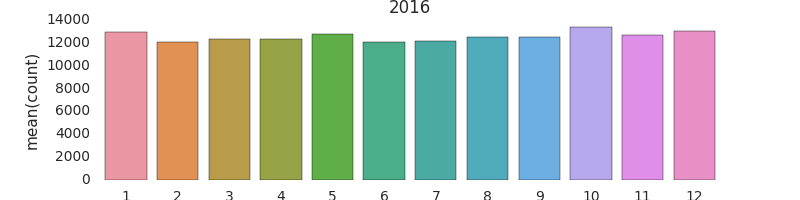

In [43]:
fig, ax2 = plt.subplots(figsize=(8,2))
item =2016
tmp = crime_per_month(q4_result_pd_df, item)
ax2 = sns.barplot(x="month", y="count", data=tmp)
ax2.set_xticklabels(tmp['month'], rotation=0)
ax2.set_title(item)
display(fig)

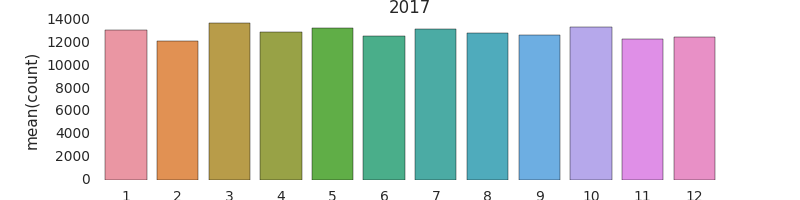

In [44]:
fig, ax2 = plt.subplots(figsize=(8,2))
item =2017
tmp = crime_per_month(q4_result_pd_df, item)
ax2 = sns.barplot(x="month", y="count", data=tmp)
ax2.set_xticklabels(tmp['month'], rotation=0)
ax2.set_title(item)
display(fig)

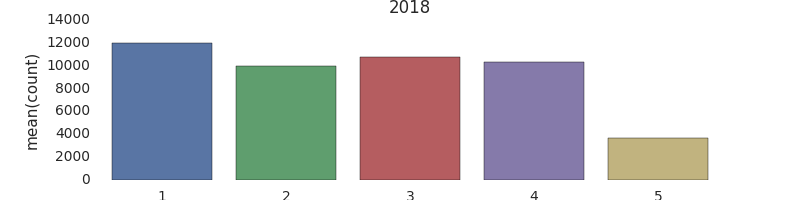

In [45]:
fig, ax2 = plt.subplots(figsize=(8,2))
item =2018
tmp = crime_per_month(q4_result_pd_df, item)
ax2 = sns.barplot(x="month", y="count", data=tmp)
ax2.set_xticklabels(tmp['month'], rotation=0)
ax2.set_title(item)
display(fig)

##### EDA5: the number of crime w.r.t the hour in certian day like 2015/12/15, 2016/12/15, 2017/12/15, 2018/10/15. Then, give my travel suggestion to visit SF.

In [47]:
def day_filter(df, yr, mo, day):
  df2 = df[(df.year == yr) & (df.month == mo) & (df.day == day) ]
  return df2

In [48]:
tmp = day_filter(df, 2015, 12, 15)
#tmp.show()

In [49]:
q5_result_pd_df = tmp.toPandas()

In [50]:
q5_result_pd_df['Time_float'] = q5_result_pd_df.Time.map(lambda x: int(x.split(':')[0]) + float(x.split(':')[1])/60)

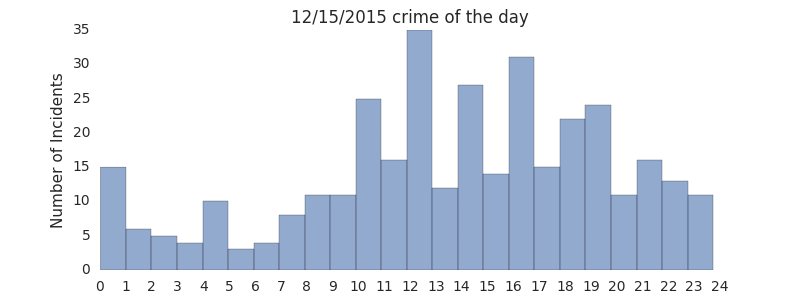

In [51]:
# visulize in a histogram plot
fig, ax = plt.subplots(figsize=[8,3])
ax.hist(q5_result_pd_df['Time_float'], bins=24, alpha = 0.6)
ax.set_xlabel('Time of a day')
ax.set_ylabel('Number of Incidents')
ax.set_xlim((0.0, 24))
ax.set_xticks( np.arange(0,25) )
ax.set_title('12/15/2015 crime of the day')
display(fig)

##### EDA6: First, find out the top-3 danger disrict, and then find out the crime event w.r.t category and time (hour) from previous result, lastly, give my advice to distribute the police based on my analysis results.

In [53]:
q6_result = df.groupBy('PdDistrict').count().orderBy('count', ascending=False)
q6_result.show()

+----------+------+
PdDistrict| count|
+----------+------+
 SOUTHERN|399762|
 MISSION|300074|
 NORTHERN|272683|
 CENTRAL|226247|
 BAYVIEW|220986|
 INGLESIDE|194173|
TENDERLOIN|191712|
 TARAVAL|166965|
 PARK|125475|
 RICHMOND|116803|
+----------+------+

In [54]:
q6_result = df.filter(df.PdDistrict.isin(['MISSION', 'SOUTHERN','NORTHERN']))

In [55]:
q6_result_pd_df = q6_result.toPandas()

##### EDA7: For different category of crime, find the percentage of resolution. Based on the output, give my hints to adjust the policy.

In [58]:
q7_result = df.groupBy('Resolution').count().orderBy('count', ascending=False)

In [59]:
q7_result.show()

+--------------------+-------+
 Resolution| count|
+--------------------+-------+
 NONE|1389431|
 ARREST, BOOKED| 524939|
 ARREST, CITED| 154761|
 LOCATED| 34463|
 PSYCHOPATHIC CASE| 29183|
 UNFOUNDED| 23797|
 JUVENILE BOOKED| 14157|
COMPLAINANT REFUS...| 8087|
DISTRICT ATTORNEY...| 7955|
 NOT PROSECUTED| 7720|
 JUVENILE CITED| 6587|
PROSECUTED BY OUT...| 5070|
EXCEPTIONAL CLEAR...| 4258|
 JUVENILE ADMONISHED| 3004|
 JUVENILE DIVERTED| 694|
CLEARED-CONTACT J...| 689|
PROSECUTED FOR LE...| 85|
+--------------------+-------+

##### EDA8 Apply Spark ML clustering for spatial data analysis. 
visualize the spatial distribution of crimes and run a Spark kmeans clustering algorithm (https://spark.apache.org/docs/latest/ml-clustering.html#k-means)

In [62]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns

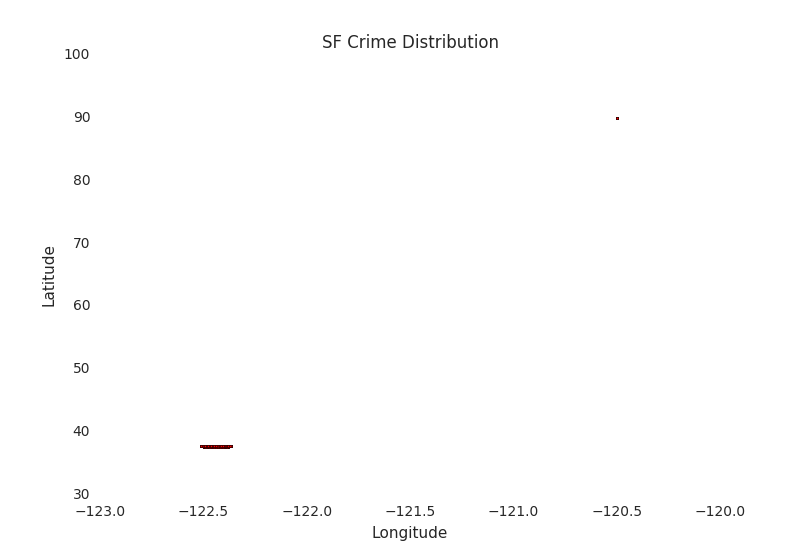

In [63]:
# make a scatter plot to show the spatial distribution of incidents
pdf = df[['Longitude','Latitude']].toPandas()
fig, ax = plt.subplots()

ax.set_title('SF Crime Distribution')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.scatter(pdf.Longitude, pdf.Latitude, s = 2, c = 'r')
# Hide the right and top spines
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
display(fig)

There is an obvious outlier at (-120.5, 90), which is probably a mistake/error in the dataset. I will remove it and plot again.

In [65]:
i = pdf.index[pdf.Latitude > 80]
pdf.drop(i, axis=0, inplace=True)
pdf.shape

Out[ 54 ]: (2214881, 2)

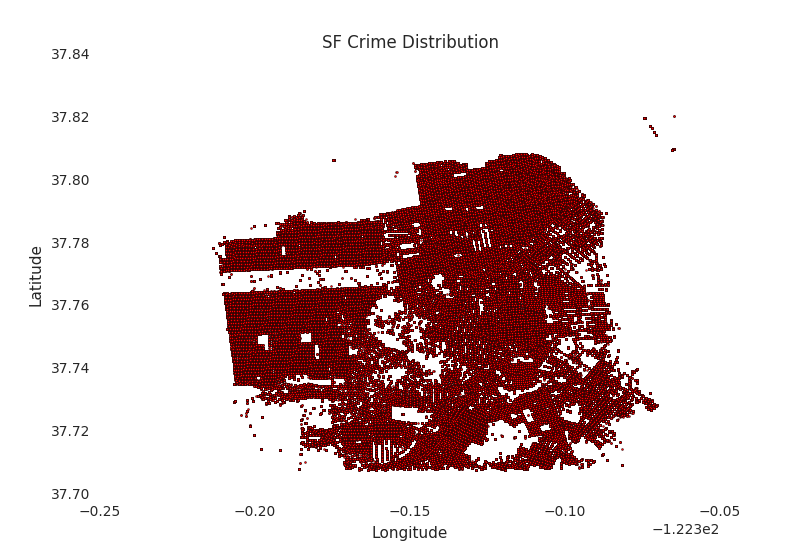

In [66]:
fig, ax = plt.subplots()

ax.set_title('SF Crime Distribution')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.scatter(pdf.Longitude, pdf.Latitude, s = 2, c = 'r')
# Hide the right and top spines
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
display(fig)

We can see that there are a lot more crimes in the north-eastern part. 

Spark ML requires the input features to be lists that are stored in a single column, usually named "features", so we need to use VectorAssembler to do this transformation for our Longitude and Latitude

In [68]:
df = df.filter(df.Latitude < 40)

In [69]:
df_coor = df[['Longitude','Latitude']]
#df_coor.drop(i, axis=0, inplace=True)

vecAssembler = VectorAssembler(inputCols=["Longitude", "Latitude"], outputCol="features")
new_df = vecAssembler.transform(df_coor)[['features']]
new_df.show(10,False)

+----------------------------------------+
features |
+----------------------------------------+
[-122.42158508300781,37.76169967651367] |
[-122.4144058227539,37.7841911315918] |
[-122.4144058227539,37.7841911315918] |
[-122.4144058227539,37.7841911315918] |
[-122.43112182617188,37.80046844482422] |
[-122.4517822265625,37.787086486816406] |
[-122.37401580810547,37.72920227050781] |
[-122.37401580810547,37.72920227050781] |
[-122.40657043457031,37.78780746459961] |
[-122.41729736328125,37.786258697509766]|
+----------------------------------------+
only showing top 10 rows

In [70]:
# fit a Spark kmeans model
kmeans = KMeans().setK(3).setSeed(1) # just a arbitrary choice of k... 
model = kmeans.fit(new_df)

# show the results
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

print("\nMemberships: ")
transformed = model.transform(new_df)
transformed.show()

Cluster Centers: 
[-122.4101503 37.73599954]
[-122.41527208 37.7818837 ]
[-122.47067433 37.7538001 ]

Memberships: 
+--------------------+----------+
 features|prediction|
+--------------------+----------+
[-122.42158508300...| 1|
[-122.41440582275...| 1|
[-122.41440582275...| 1|
[-122.41440582275...| 1|
[-122.43112182617...| 1|
[-122.45178222656...| 1|
[-122.37401580810...| 0|
[-122.37401580810...| 0|
[-122.40657043457...| 1|
[-122.41729736328...| 1|
[-122.41335296630...| 1|
[-122.41335296630...| 1|
[-122.41335296630...| 1|
[-122.41335296630...| 1|
[-122.43219757080...| 1|
[-122.42227935791...| 1|
[-122.42227935791...| 1|
[-122.38793945312...| 0|
[-122.45864105224...| 2|
[-122.38977813720...| 0|
+--------------------+----------+
only showing top 20 rows

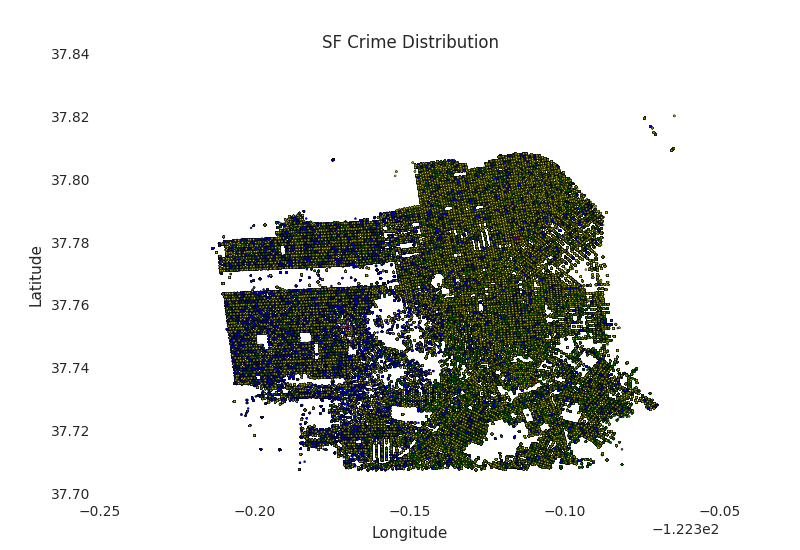

In [71]:
# cluster centers
long_centers = [i for i, _ in centers]
lat_centers = [i for _, i in centers]

# assign colors for each data points based on their memberships
memberships = transformed.toPandas().loc[:,'prediction'].values
clusters2colors = {0: 'g', 1: 'y', 2: 'b'}
colors = [clusters2colors[i] for i in memberships]

fig, ax = plt.subplots()
ax.set_title('SF Crime Distribution')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.scatter(pdf.Longitude, pdf.Latitude, s = 2, c=colors)
ax.scatter(long_centers, lat_centers, s = 50, c = 'red', marker = '+')
display(fig)

### Conclusion. 
Use four sentences to summary your work. Like what you have done, how to do it, what the techinical steps, what is your business impact. 
More details are appreciated. You can think about this a report for your manager. Then, you need to use this experience to prove that you have strong background on big  data analysis. 
Point 1:  what is your story ? and why you do this work ?   
Point 2:  how can you do it ?  keywords: Spark, Spark SQL, Dataframe, Data clean, Data visulization, Data size, clustering, OLAP,   
Point 3:  what do you learn from the data ?  keywords: crime, trend, advising, conclusion, runtime

##### Time series analysis (see another notebook)
This part is not based on Spark, and only based on Pandas Time Series package.  Reference(
https://zhuanlan.zhihu.com/p/35282988  
https://zhuanlan.zhihu.com/p/35128342  
https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html  
https://www.howtoing.com/a-guide-to-time-series-forecasting-with-arima-in-python-3  
https://www.joinquant.com/post/9576?tag=algorithm  
https://blog.csdn.net/u012052268/article/details/79452244  )